
--- Running scenario: none ---
  Healthspan age (mean X crosses func_threshold): 71.4
  Lifespan age (death): 95.60000000000001
  Cause of death: Neuro
  Gap (years in low functional state): 24.200000000000003

--- Running scenario: exercise ---
  Healthspan age (mean X crosses func_threshold): 82.7
  Lifespan age (death): 119.7
  Cause of death: Neuro
  Gap (years in low functional state): 37.0

--- Running scenario: drug ---
  Healthspan age (mean X crosses func_threshold): 77.0
  Lifespan age (death): 101.9
  Cause of death: Neuro
  Gap (years in low functional state): 24.900000000000006

--- Running scenario: organ1 ---
  Healthspan age (mean X crosses func_threshold): 73.80000000000001
  Lifespan age (death): 91.9
  Cause of death: Neuro
  Gap (years in low functional state): 18.099999999999994

--- Running scenario: organ2 ---
  Healthspan age (mean X crosses func_threshold): 85.2
  Lifespan age (death): 92.0
  Cause of death: Neuro
  Gap (years in low functional state): 6.79999

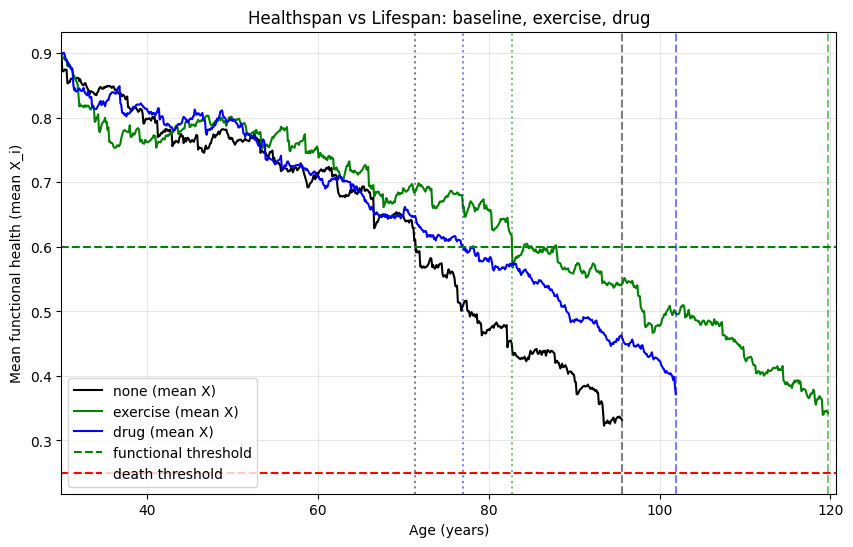

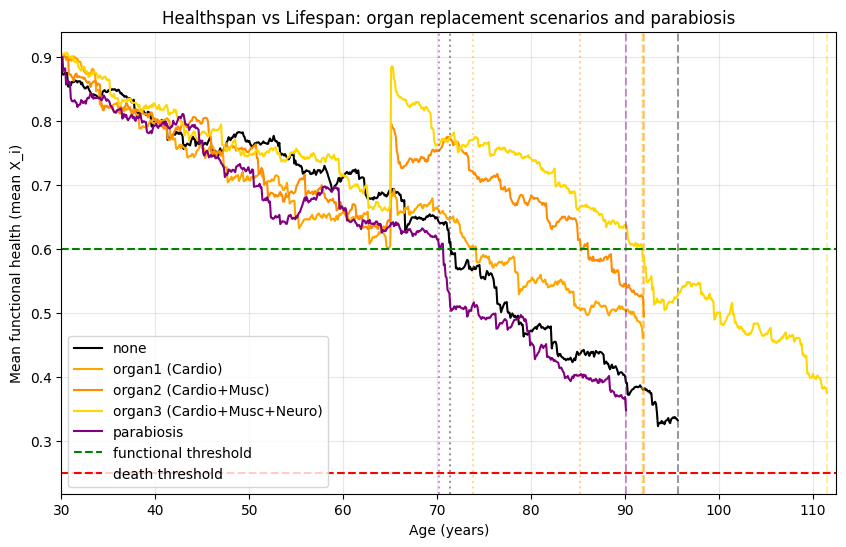

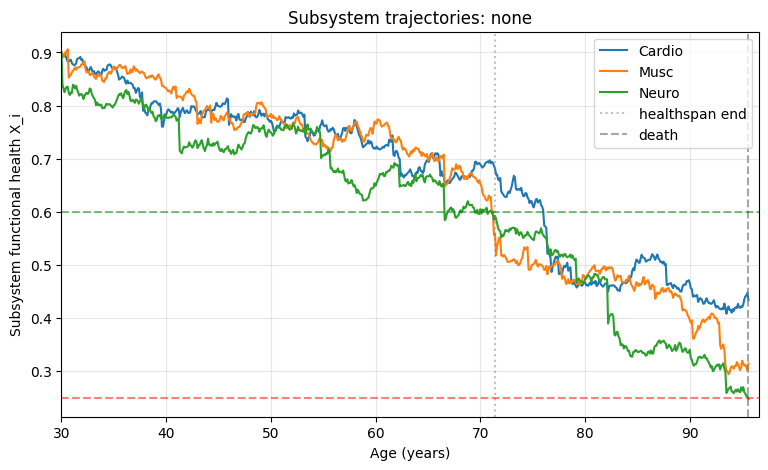

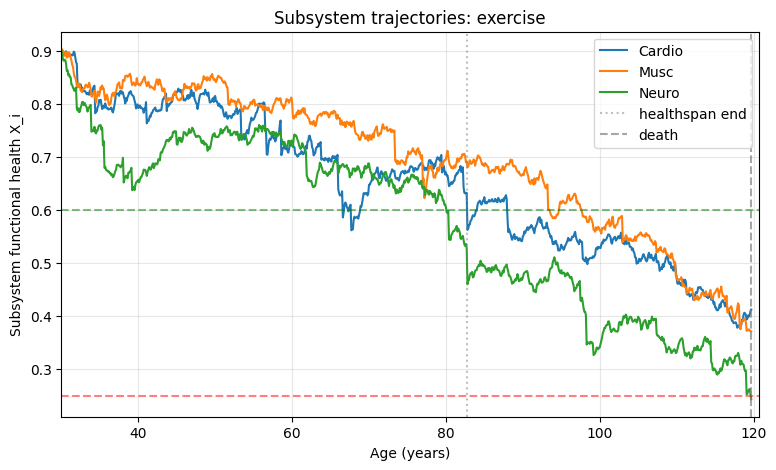

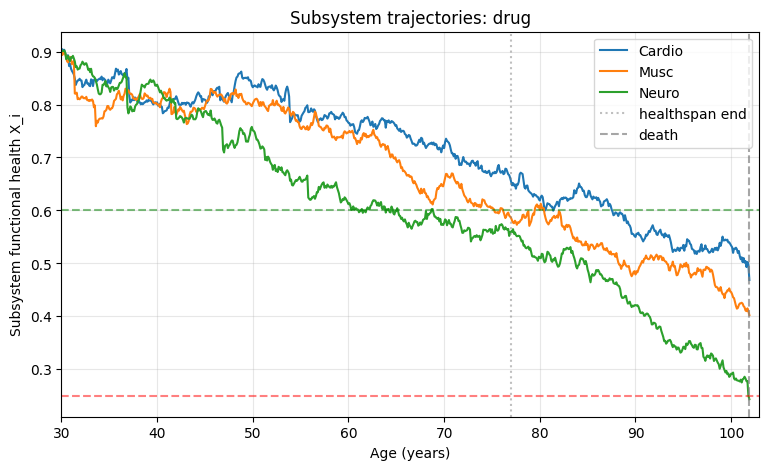

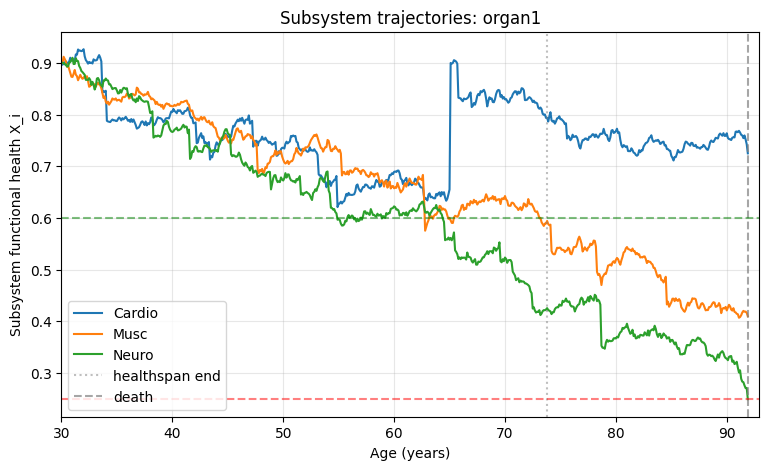

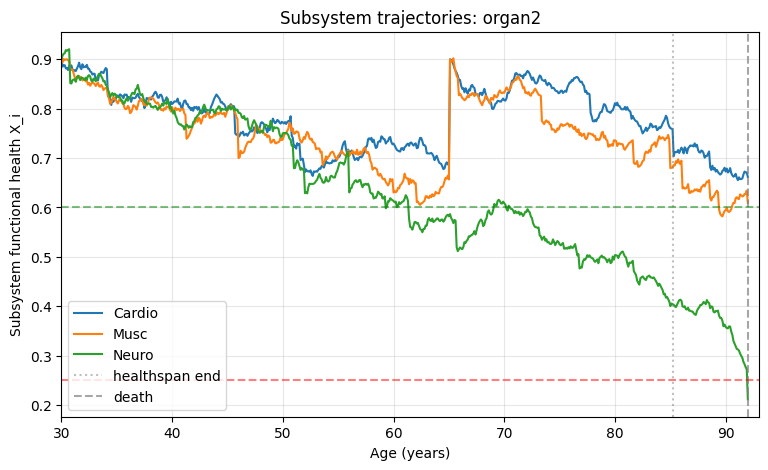

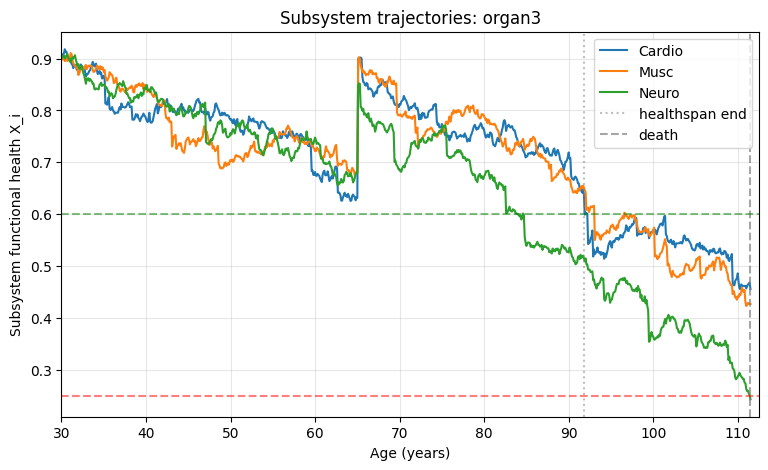

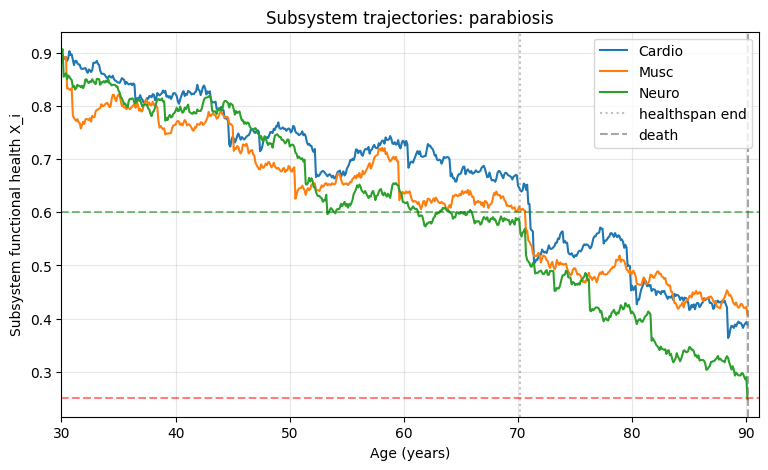


Monte Carlo baseline (none):
  total deaths: 300
  Cardio: 4 (1.33%)
  Musc: 68 (22.67%)
  Neuro: 228 (76.00%)


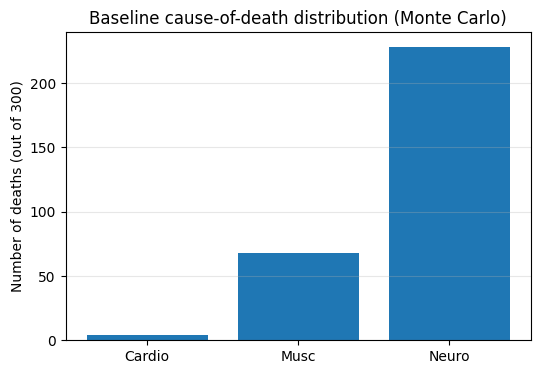

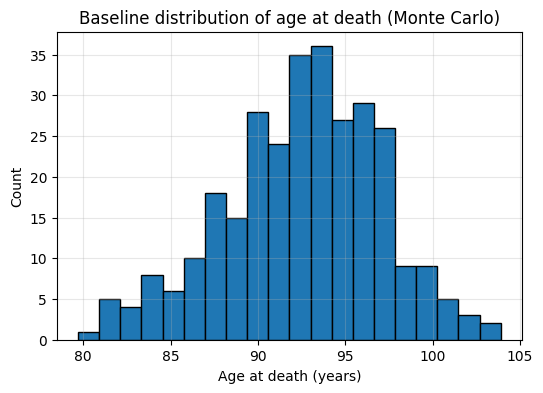

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# MODEL SETTINGS
# ============================================================
n_nodes = 3
node_names = ["Cardio", "Musc", "Neuro"]

start_age = 30.0
years = 90.0          # simulate 90 years  → up to age 120
dt = 0.1              # years per timestep
timesteps = int(years / dt)

# ============================================================
# INITIAL CONDITIONS
# ============================================================
# Functional health (fast variable, X_i in [0,1])
X0 = np.array([0.9, 0.9, 0.9])   # start slightly below perfect

# Structural damage (slow variable, D_i ~ [0,1+])
D0 = np.array([0.1, 0.1, 0.1])   # young adult-ish

# ============================================================
# BASELINE PARAMETERS (NO INTERVENTION)
# ============================================================

# ---- Decay: baseline + sensitivity to structural damage ----
# Effective decay_i(D_i) = base_decay[i] * (1 + beta_decay[i] * D_i)
# <<< tweaked for ~symmetric hazards
base_decay = np.array([0.020, 0.020, 0.020])  # Cardio, Musc, Neuro
beta_decay = np.array([1.5, 1.5, 1.5])        # how strongly damage increases decay

# ---- Recovery: baseline + sensitivity to damage ----
# Effective recovery_i(D_i) = base_recovery[i] * (1 - gamma_recovery[i] * D_i)
base_recovery = np.array([0.30, 0.25, 0.20])  # per year, young baseline
gamma_recovery = np.array([1.0, 1.0, 1.0])    # how strongly damage slows recovery

# ---- Damage-limited max health: X_max = 1 - k_ceiling * D ----
# <<< tweaked for symmetry
k_ceiling = np.array([0.6, 0.6, 0.6])         # same ceiling effect for all

# ---- Coupling (shock propagation) base matrix ----
# C_base[i,j] = how much a shock in j affects i directly
# <<< symmetric, moderate coupling
C_base = np.array([
    [0.0, 0.10, 0.10],
    [0.10, 0.0, 0.10],
    [0.10, 0.10, 0.0],
])
gamma_coupling = 1.0   # how strongly damage amplifies propagation

# ---- Shock process (baseline) ----
# <<< same shock exposure across systems
shock_prob_base = np.array([0.018, 0.018, 0.018])  # per timestep, per node
shock_mean_base = np.array([0.04, 0.04, 0.04])     # average function loss if hit
shock_std_base  = np.array([0.015, 0.015, 0.015])  # variability

# ---- Structural damage accumulation ----
# D increases when X is low + when shocks hit
alpha_damage_from_low_X_base = 0.03  # per year, from (1 - X)
beta_damage_from_shock       = 0.4   # per unit shock magnitude

# ---- Noise on functional health ----
noise_std = 0.005

# ---- Thresholds (healthspan & death) ----
func_threshold  = 0.60    # mean X above this = good function
death_threshold = 0.25    # if any X_i < this => death

# ============================================================
# INTERVENTION PARAMETERS
# ============================================================

# ---- Exercise: lifestyle-like (recovery & damage) ----
# Strong on healthspan, modest on lifespan.
exercise_start_age = 40.0
exercise_recovery_gain = 0.3         # +30% recovery when active
exercise_damage_reduction = 0.3      # -30% damage-from-low-X when active

# ---- Drug: shock-modulator (shock channel) ----
# Stronger on acute mortality (shocks) than on slow decay.
drug_start_age = 60.0
drug_shock_factor = 0.4   # multiply shock prob & magnitude by this (<1)

# ---- Organ replacement: scenarios with 1, 2 or 3 organs ----
organ_replacement_age = 65.0

# subsets of organs
# 0 = Cardio, 1 = Musc, 2 = Neuro
organ_scenarios = {
    "organ1": np.array([0]),        # cardio only
    "organ2": np.array([0, 1]),     # cardio + musc
    "organ3": np.array([0, 1, 2]),  # all three
}

# Target structural damage after replacement
# (not fully young, but substantially improved)
organ_replacement_D = np.array([0.15, 0.15, 0.25])   # Cardio, Musc, Neuro

# Target functional health after replacement
organ_replacement_X = np.array([0.90, 0.90, 0.85])   # Cardio, Musc, Neuro

# ---- Parabiosis: systemic environment tweak, not magic rejuvenation ----
parabiosis_start_age = 55.0

# length of sustained effect & its decay
parabiosis_duration   = 8.0       # years over which it has meaningful effect
parabiosis_strength_k = 0.6       # exponential decay constant

# process-level modulations at full strength
parabiosis_recovery_gain          = 0.40   # better recovery
parabiosis_decay_reduction        = 0.20   # 20% less intrinsic decay at peak
parabiosis_alpha_reduction        = 0.40   # less damage from low X
parabiosis_shock_damage_reduction = 0.30   # shocks scar tissue less

# ============================================================
# HELPER FUNCTIONS
# ============================================================
def effective_decay(D):
    """decay_i(D_i) = base_decay[i] * (1 + beta_decay[i] * D_i)"""
    return base_decay * (1.0 + beta_decay * np.clip(D, 0.0, 1.0))

def effective_recovery(D):
    """recovery_i(D_i) = base_recovery[i] * (1 - gamma_recovery[i] * D_i)"""
    return base_recovery * (1.0 - gamma_recovery * np.clip(D, 0.0, 1.0))

def max_health(D):
    """X_max_i(D_i) = 1 - k_ceiling[i] * D_i"""
    return 1.0 - k_ceiling * np.clip(D, 0.0, 1.0)

def coupling_matrix(D):
    """C_ij(D) = C_base_ij * (1 + gamma_coupling * avg_damage(i,j))"""
    D_clipped = np.clip(D, 0.0, 1.0)
    avg_damage = (D_clipped[None, :] + D_clipped[:, None]) / 2.0
    return C_base * (1.0 + gamma_coupling * avg_damage)

def update_structural_damage(
    D, X, total_shock_mag,
    alpha_damage_from_low_X, dt,
    shock_damage_scale=1.0
):
    """
    Slow structural damage update:
    - increases when X is low
    - increases when shocks hit
    shock_damage_scale lets interventions reduce how much
    shocks translate into structural damage.
    """
    D_new = D.copy()
    D_new += alpha_damage_from_low_X * (1.0 - np.clip(X, 0.0, 1.0)) * dt
    D_new += beta_damage_from_shock * (total_shock_mag * shock_damage_scale) * dt
    return np.clip(D_new, 0.0, 1.5)

# ============================================================
# CORE SIMULATION FUNCTION
# ============================================================
def run_sim(intervention="none"):
    """
    Run one simulation for a given intervention:
      - "none": baseline
      - "exercise": lifestyle (recov + damage)
      - "drug": shock-modulator
      - "organ1": single-organ replacement (cardio)
      - "organ2": two-organ replacement (cardio + musc)
      - "organ3": three-organ replacement (all)
      - "parabiosis": systemic environment tweak
    Returns:
      history_age, history_X, history_D, healthspan_age, death_age, cause_of_death
    """
    X = X0.copy()
    D = D0.copy()

    history_X = []
    history_D = []
    history_age = []

    healthspan_age = None
    death_age = None
    cause_of_death = None

    organ_done = False  # ensure organ replacement happens once

    for t in range(timesteps):
        age = start_age + t * dt

        # record CURRENT state
        history_age.append(age)
        history_X.append(X.copy())
        history_D.append(D.copy())

        # --- effective parameters from structural damage ---
        dec = effective_decay(D)
        rec = effective_recovery(D)
        Xmax = max_health(D)
        C = coupling_matrix(D)

        # default damage dynamics
        alpha_damage_from_low_X = alpha_damage_from_low_X_base
        shock_damage_scale = 1.0

        # --- exercise intervention on recovery & damage ---
        if intervention == "exercise" and age >= exercise_start_age:
            rec = rec * (1.0 + exercise_recovery_gain)
            alpha_damage_from_low_X = (
                alpha_damage_from_low_X_base * (1.0 - exercise_damage_reduction)
            )

        # --- parabiosis: process-level modulation with diminishing returns ---
        if intervention == "parabiosis" and age >= parabiosis_start_age:
            years_on_para = age - parabiosis_start_age
            if years_on_para <= parabiosis_duration:
                # strength decays from 1 → ~0 over 'parabiosis_duration' years
                strength = float(np.exp(-parabiosis_strength_k * years_on_para))
                # slightly better recovery, slightly lower decay
                rec = rec * (1.0 + parabiosis_recovery_gain * strength)
                dec = dec * (1.0 - parabiosis_decay_reduction * strength)
                # less structural damage per year and per shock
                alpha_damage_from_low_X = (
                    alpha_damage_from_low_X_base
                    * (1.0 - parabiosis_alpha_reduction * strength)
                )
                shock_damage_scale = 1.0 - parabiosis_shock_damage_reduction * strength

        # --- baseline decay contribution ---
        dX_decay = -dec * X * dt

        # --- determine shock parameters (possibly modified by drug) ---
        shock_prob = shock_prob_base.copy()
        shock_mean = shock_mean_base.copy()
        shock_std  = shock_std_base.copy()
        if intervention == "drug" and age >= drug_start_age:
            shock_prob = shock_prob * drug_shock_factor
            shock_mean = shock_mean * drug_shock_factor

        # --- sample local shocks ---
        local_shock = np.zeros(n_nodes)
        for i in range(n_nodes):
            if np.random.rand() < shock_prob[i]:
                mag = np.random.normal(shock_mean[i], shock_std[i])
                mag = max(mag, 0.0)
                local_shock[i] = mag

        # --- propagate shocks ---
        propagated_shock = C @ local_shock
        total_shock = local_shock + propagated_shock

        # --- apply decay and shocks ---
        X_after_shock = X + dX_decay - total_shock

        # --- recovery toward damage-limited ceiling ---
        rec_clamped = np.clip(rec, 0.0, None)
        dX_recovery = rec_clamped * (Xmax - X_after_shock) * dt
        X_new = X_after_shock + dX_recovery

        # --- noise ---
        X_new += np.random.normal(0.0, noise_std, size=n_nodes)

        # --- clamp functional health to [0,1] ---
        X_new = np.clip(X_new, 0.0, 1.0)

        # --- update structural damage (using possibly reduced shock impact) ---
        D_new = update_structural_damage(
            D, X_new, total_shock,
            alpha_damage_from_low_X, dt,
            shock_damage_scale=shock_damage_scale
        )

        # --- organ replacement (discrete multi-system reset) ---
        if intervention.startswith("organ") and (not organ_done) and age >= organ_replacement_age:
            nodes = organ_scenarios[intervention]  # which organs
            D_new[nodes] = organ_replacement_D[nodes]
            X_new[nodes] = organ_replacement_X[nodes]
            organ_done = True

        # --- healthspan & death detection (use NEW state) ---
        mean_X = X_new.mean()
        if healthspan_age is None and mean_X < func_threshold:
            healthspan_age = age

        if np.any(X_new < death_threshold):
            death_age = age

            # probabilistic cause-of-death assignment
            deficits = np.maximum(death_threshold - X_new, 0.0)
            if deficits.sum() > 0:
                probs = deficits / deficits.sum()
                cause_idx = np.random.choice(np.arange(n_nodes), p=probs)
            else:
                cause_idx = int(np.argmin(X_new))
            cause_of_death = int(cause_idx)

            # overwrite last recorded state with the death-state
            history_X[-1] = X_new.copy()
            history_D[-1] = D_new.copy()
            break

        # move to next step
        X, D = X_new, D_new

    history_X = np.array(history_X)
    history_D = np.array(history_D)
    history_age = np.array(history_age)

    return history_age, history_X, history_D, healthspan_age, death_age, cause_of_death

# ============================================================
# RUN SCENARIOS (single trajectories for visualization)
# ============================================================
scenarios = ["none", "exercise", "drug",
             "organ1", "organ2", "organ3",
             "parabiosis"]

colors = {
    "none": "black",
    "exercise": "green",
    "drug": "blue",
    "organ1": "orange",
    "organ2": "darkorange",
    "organ3": "gold",
    "parabiosis": "purple",
}

results = {}
for mode in scenarios:
    print(f"\n--- Running scenario: {mode} ---")
    age, X_hist, D_hist, hspan, dspan, cod = run_sim(mode)
    results[mode] = {
        "age": age,
        "X": X_hist,
        "D": D_hist,
        "healthspan": hspan,
        "lifespan": dspan,
        "cause": cod,
    }
    print("  Healthspan age (mean X crosses func_threshold):", hspan)
    print("  Lifespan age (death):", dspan)
    print("  Cause of death:", node_names[cod] if cod is not None else None)
    if hspan is not None and dspan is not None:
        print("  Gap (years in low functional state):", dspan - hspan)

# ============================================================
# PLOTS – HEALTHSPAN vs LIFESPAN
# ============================================================

def max_death_age(modes):
    deaths = [results[m]["lifespan"] for m in modes if results[m]["lifespan"] is not None]
    if len(deaths) == 0:
        return start_age + years
    return max(deaths)

# 1) Baseline vs exercise vs drug
compare1 = ["none", "exercise", "drug"]
plt.figure(figsize=(10,6))
for mode, color in [("none", "black"),
                    ("exercise", "green"),
                    ("drug", "blue")]:
    age = results[mode]["age"]
    X_hist = results[mode]["X"]
    mean_X = X_hist.mean(axis=1)
    plt.plot(age, mean_X, label=f"{mode} (mean X)", color=color)

    hspan = results[mode]["healthspan"]
    dspan = results[mode]["lifespan"]
    if hspan is not None:
        plt.axvline(hspan, color=color, linestyle=":", alpha=0.5)
    if dspan is not None:
        plt.axvline(dspan, color=color, linestyle="--", alpha=0.5)

plt.axhline(func_threshold, color="green", linestyle="--", label="functional threshold")
plt.axhline(death_threshold, color="red", linestyle="--", label="death threshold")
plt.xlabel("Age (years)")
plt.ylabel("Mean functional health (mean X_i)")
plt.title("Healthspan vs Lifespan: baseline, exercise, drug")

xmax1 = max_death_age(compare1) + 1.0
plt.xlim(start_age, xmax1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2) Baseline vs organ replacements vs parabiosis
compare2 = ["none", "organ1", "organ2", "organ3", "parabiosis"]
plt.figure(figsize=(10,6))
for mode, color, label in [
    ("none",    "black",      "none"),
    ("organ1",  "orange",     "organ1 (Cardio)"),
    ("organ2",  "darkorange", "organ2 (Cardio+Musc)"),
    ("organ3",  "gold",       "organ3 (Cardio+Musc+Neuro)"),
    ("parabiosis", "purple",  "parabiosis"),
]:
    age = results[mode]["age"]
    X_hist = results[mode]["X"]
    mean_X = X_hist.mean(axis=1)
    plt.plot(age, mean_X, label=f"{label}", color=color)

    hspan = results[mode]["healthspan"]
    dspan = results[mode]["lifespan"]
    if hspan is not None:
        plt.axvline(hspan, color=color, linestyle=":", alpha=0.4)
    if dspan is not None:
        plt.axvline(dspan, color=color, linestyle="--", alpha=0.4)

plt.axhline(func_threshold, color="green", linestyle="--", label="functional threshold")
plt.axhline(death_threshold, color="red", linestyle="--", label="death threshold")
plt.xlabel("Age (years)")
plt.ylabel("Mean functional health (mean X_i)")
plt.title("Healthspan vs Lifespan: organ replacement scenarios and parabiosis")

xmax2 = max_death_age(compare2) + 1.0
plt.xlim(start_age, xmax2)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ============================================================
# PER-SCENARIO, PER-SUBSYSTEM PLOTS
# ============================================================
for mode in scenarios:
    age = results[mode]["age"]
    X_hist = results[mode]["X"]
    hspan = results[mode]["healthspan"]
    dspan = results[mode]["lifespan"]

    plt.figure(figsize=(9,5))
    for i, name in enumerate(node_names):
        plt.plot(age, X_hist[:, i], label=name)

    if hspan is not None:
        plt.axvline(hspan, color="gray", linestyle=":", alpha=0.5, label="healthspan end")
    if dspan is not None:
        plt.axvline(dspan, color="gray", linestyle="--", alpha=0.7, label="death")

    plt.axhline(func_threshold, color="green", linestyle="--", alpha=0.5)
    plt.axhline(death_threshold, color="red", linestyle="--", alpha=0.5)
    plt.xlabel("Age (years)")
    plt.ylabel("Subsystem functional health X_i")
    plt.title(f"Subsystem trajectories: {mode}")

    if dspan is not None:
        plt.xlim(start_age, dspan + 1.0)
    else:
        plt.xlim(start_age, start_age + years)

    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# ============================================================
# MONTE CARLO: BASELINE CAUSES OF DEATH
# ============================================================
n_runs = 300
cause_counts = np.zeros(n_nodes, dtype=int)
ages_at_death = []

for r in range(n_runs):
    age, X_hist, D_hist, hspan, dspan, cod = run_sim("none")
    if cod is not None and dspan is not None:
        cause_counts[cod] += 1
        ages_at_death.append(dspan)

total_deaths = cause_counts.sum()
print("\nMonte Carlo baseline (none):")
print("  total deaths:", total_deaths)
for i, name in enumerate(node_names):
    frac = cause_counts[i] / total_deaths if total_deaths > 0 else 0.0
    print(f"  {name}: {cause_counts[i]} ({frac:.2%})")

# Bar plot for causes of death
plt.figure(figsize=(6,4))
plt.bar(node_names, cause_counts)
plt.ylabel("Number of deaths (out of %d)" % n_runs)
plt.title("Baseline cause-of-death distribution (Monte Carlo)")
plt.grid(axis="y", alpha=0.3)
plt.show()

# Histogram of ages at death
if ages_at_death:
    plt.figure(figsize=(6,4))
    plt.hist(ages_at_death, bins=20, edgecolor="black")
    plt.xlabel("Age at death (years)")
    plt.ylabel("Count")
    plt.title("Baseline distribution of age at death (Monte Carlo)")
    plt.grid(alpha=0.3)
    plt.show()

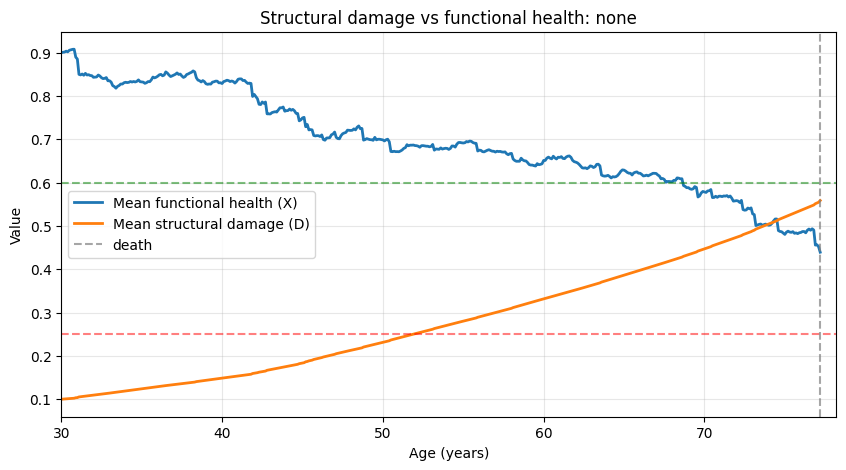

In [7]:
mode = "none"
age = results[mode]["age"]
X_hist = results[mode]["X"]
D_hist = results[mode]["D"]

mean_X = X_hist.mean(axis=1)
mean_D = D_hist.mean(axis=1)

plt.figure(figsize=(10,5))
plt.plot(age, mean_X, label="Mean functional health (X)", linewidth=2)
plt.plot(age, mean_D, label="Mean structural damage (D)", linewidth=2)
plt.axhline(func_threshold, color="green", linestyle="--", alpha=0.5)
plt.axhline(death_threshold, color="red", linestyle="--", alpha=0.5)
if results[mode]["lifespan"] is not None:
    plt.axvline(results[mode]["lifespan"], color="gray", linestyle="--", alpha=0.7, label="death")

plt.xlabel("Age (years)")
plt.ylabel("Value")
plt.title(f"Structural damage vs functional health: {mode}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(start_age, results[mode]["lifespan"] + 1.0)
plt.show()


In [8]:
def run_many(intervention, n_runs=100):
    hs = []
    ls = []
    for _ in range(n_runs):
        age, X_hist, D_hist, hspan, dspan = run_sim(intervention)
        hs.append(hspan)
        ls.append(dspan)
    return np.array(hs), np.array(ls)

mc_results = {}
for mode in ["none", "exercise", "drug", "organ3", "parabiosis"]:
    hs, ls = run_many(mode, n_runs=80)
    mc_results[mode] = (hs, ls)

plt.figure(figsize=(8,7))
for mode, color in [("none","black"),
                    ("exercise","green"),
                    ("drug","blue"),
                    ("organ3","gold"),
                    ("parabiosis","purple")]:
    hs, ls = mc_results[mode]
    plt.scatter(hs, ls, alpha=0.5, s=15, color=color, label=mode)

plt.plot([start_age, start_age+years],[start_age, start_age+years],
         linestyle="--", color="gray", alpha=0.5)

plt.xlabel("Healthspan (age at mean X < threshold)")
plt.ylabel("Lifespan (death age)")
plt.title("Healthspan vs Lifespan across stochastic runs")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


ValueError: too many values to unpack (expected 5)